In [32]:
!pip install category_encoders
!pip install xgboost
!pip install scikit-learn
!pip install imblearn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/258.3 kB ? eta -:--:--
   ------ --------------------------------- 41.0/258.3 kB 1.9 MB/s eta 0:00:01
   ----------- ---------------------------- 71.7/258.3 kB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 112.6/258.3 kB 1.1 MB/s eta 0:00:01
   -------------------------- ------------- 174.1/258.3 kB 1.0 MB/s eta 0:00:01
   --------------------------------- ---- 225.3/258.3 kB 981.9 kB/s eta 0:00:01
   -------------------------------------  256.0/258.3 kB 983.0 kB/s eta 0:00:01
   -------------------------------------  256.0/258.3 kB 983.0 kB/s eta 0:00:01
   -------------------------------------  256.0/258.3 kB 983.0 kB/s eta 0:00:01
   -------------------------------------- 258.3/258.3 kB 634.5 kB/s eta 0:00:00


In [2]:
import missingno as msno
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, StandardScaler
from category_encoders import BinaryEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

# Context



Customer churn, or loss of customers, is something that should be avoided by all companies, as SaaS companies, or companies that offer services as their main source of revenue, require recurring revenues from retained customers which are cheaper to keep than getting new customers. (Source: https://www.paddle.com/resources/customer-churn), ultimately hurting profits in the long run; a suboptimal result for the owners and shareholders of the company.

Specifically, these are the most common reasons customers churn:
- The customers attracted are not in the ideal target market.
- Poor customer support.
- Competitors have higher quality products than us.
- Suboptimal pricing of our products.
- Customers are seeing bugs in the product that they think can’t be fixed.
- The customers can’t see the product’s value.
- The product isn’t taking the customers to their desired results.
(Source: https://www.paddle.com/resources/churn-causes)

But churn can also indicate problems with either the product or the user's experience (Source: https://www.investopedia.com/terms/c/churnrate.asp), and if paired with data on the customers that churned out, we can analyze the characteristics that determine whether they churn or not, and hence determine the existing customers at most risk of being churned.

# Objective

To find the attributes that contribute the most to churn (according to the DataFrame provided) and, from there, create a prediction model by using Machine Learning to help identify customers at most risk of churning in the future.

The highest recall score of the existing rule-based (Non-ML) model is 0.570342. Our goal is to use ML methods to beat this score.

This model can be used by both customer support and product development teams in order to better coordinate efforts to get feedback from customers at risk which can be used to guide both future product development and ways to tailor user experience with the product.

If we prefer a more automated approach, its results can also be used for email marketing personnel to know which customers to launch retention campaigns on, similar to how customer support would approach such situations.

# Metric Evaluation Method Used: Recall Score

This calculates the amount of positives (Churn = Yes) correctly predicted by the model as a percentage of all the actual positives.

Reason: It is imperative for a services company to prevent customers from churning in order to protect their profits. The cost of extra effort spent on customers that might have never been at risk of churning in the first place will be far outclassed by the benefits of stopping those indeed at risk of churning.

# Data Understanding Phase

In [3]:
ChurnRaw = pd.read_csv('data_telco_customer_churn.csv')
ChurnRaw

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


Data dictionary:

| Column | Explanation |
| ---- | ---- |
| Dependents | Does the customer have dependents? |
| Tenure | Time customer stayed in company (in months) |
| InternetService | Does the customer have internet service? |
| OnlineSecurity | Does the customer have online security? |
| OnlineBackup | Can the customer backup files online? |
| DeviceProtection | Is the customer’s device protected while online? |
| TechSupport | Can the customer contact tech support? |
| Contract | How long does the contract with the customer last? |
| PaperlessBilling | Are the bills to the customer issued online? |
| MonthlyCharges | How much is the customer charged per month? |
| Churn | Did the customer stop using our service? |

## Dataset Unique Values

In [4]:
ChurnRaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [5]:
NaNChecker = []
for i in ChurnRaw:
  NaNChecker.append( [i, ChurnRaw[i].nunique(), ChurnRaw[i].unique()])

Result = pd.DataFrame(columns=['Column', 'Number of Unique Values', 'All Unique Values'], data=NaNChecker)
Result

,Column,Number of Unique Values,All Unique Values
0,Dependents,2,"[Yes, No]"
1,tenure,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1..."
2,OnlineSecurity,3,"[No, Yes, No internet service]"
3,OnlineBackup,3,"[No, Yes, No internet service]"
4,InternetService,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,3,"[Yes, No internet service, No]"
6,TechSupport,3,"[Yes, No, No internet service]"
7,Contract,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,2,"[Yes, No]"
9,MonthlyCharges,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7,..."


## Checking for Duplicates

In [6]:
ChurnRaw[ChurnRaw.duplicated(keep=False)]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
87,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.35,No
187,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
204,No,18,No internet service,No internet service,No,No internet service,No internet service,One year,No,20.10,No
233,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.90,No
264,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,74.45,Yes
...,...,...,...,...,...,...,...,...,...,...,...
4759,No,4,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.05,No
4786,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.35,No
4788,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,70.10,Yes
4866,No,1,No,No,DSL,No,No,Month-to-month,Yes,55.00,Yes


## Checking for Missingno

In [7]:
ChurnRaw.isna().count()

Dependents          4930
tenure              4930
OnlineSecurity      4930
OnlineBackup        4930
InternetService     4930
DeviceProtection    4930
TechSupport         4930
Contract            4930
PaperlessBilling    4930
MonthlyCharges      4930
Churn               4930
dtype: int64

<Axes: >

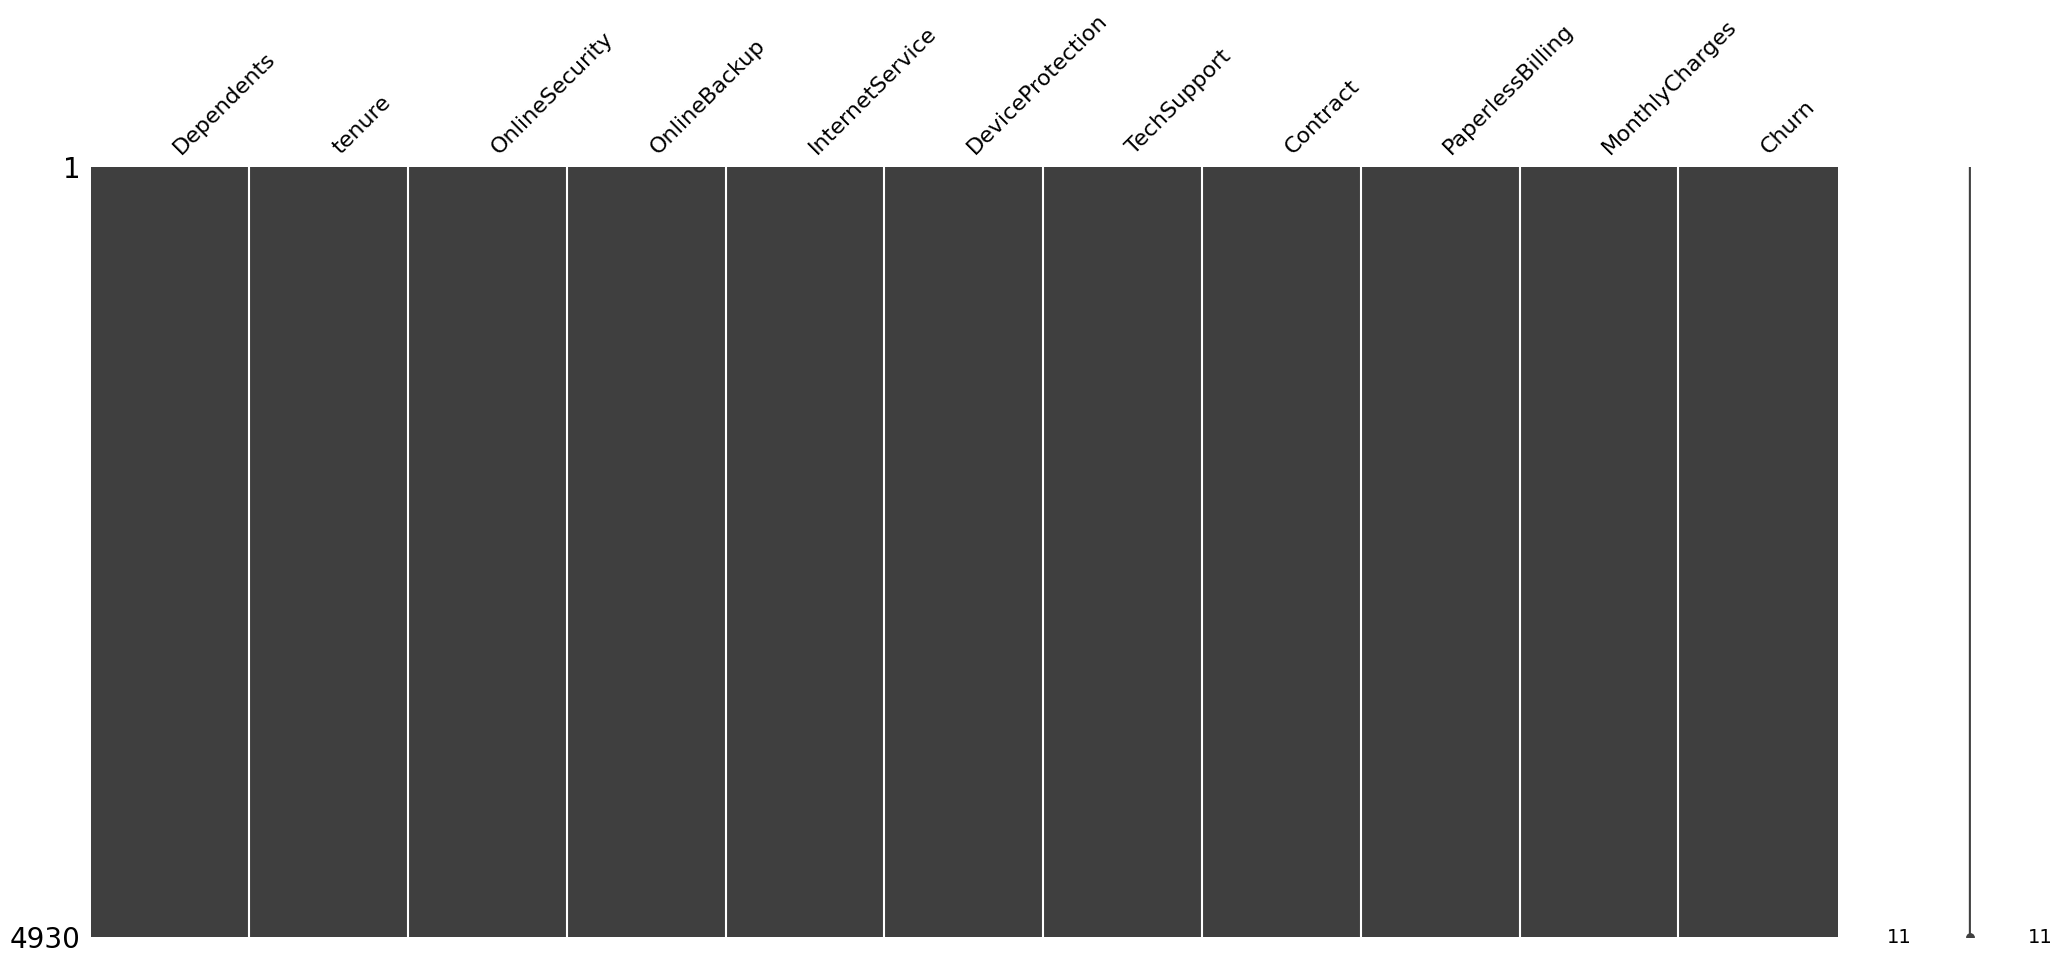

In [8]:
msno.matrix(ChurnRaw)

# Preliminary Analysis

- All columns will be kept as data for training the machine learning model.
- The duplicated values will all be kept. This is because there is no indication that the duplicated entries are coming from the exact same customer (i.e. no Customer IDs).

## Numerical Data

In [9]:
ChurnRaw.describe()

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


## Normality Testing

In [10]:
from scipy.stats import normaltest

for setiap_kolom in ChurnRaw.select_dtypes(include='number'):
  print(normaltest(ChurnRaw[setiap_kolom]))

NormaltestResult(statistic=np.float64(55241.997734023615), pvalue=np.float64(0.0))
NormaltestResult(statistic=np.float64(6038.989340855942), pvalue=np.float64(0.0))


i.e. the data is not normally distributed.

## Outlier Detection

### IQR Methodology

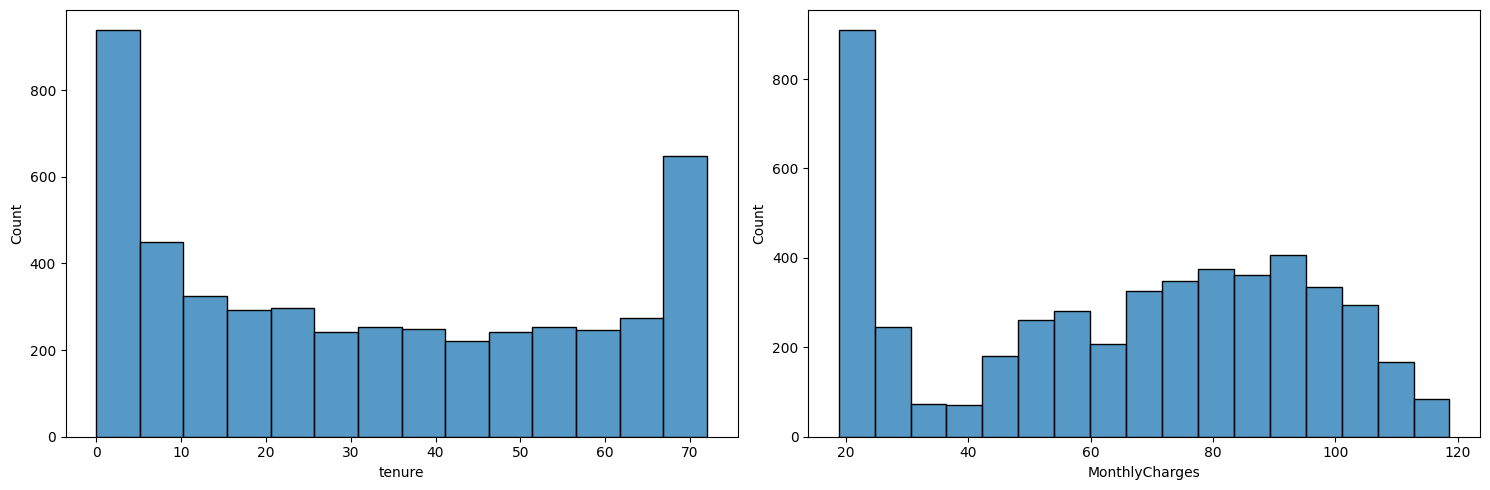

In [11]:
plt.figure(figsize = (15,5))

Pos = 1
for setiap_kolom in ChurnRaw.select_dtypes(include = 'number'):
  plt.subplot(1,2,Pos)
  sns.histplot(ChurnRaw[setiap_kolom])
  Pos = Pos + 1
  plt.tight_layout()

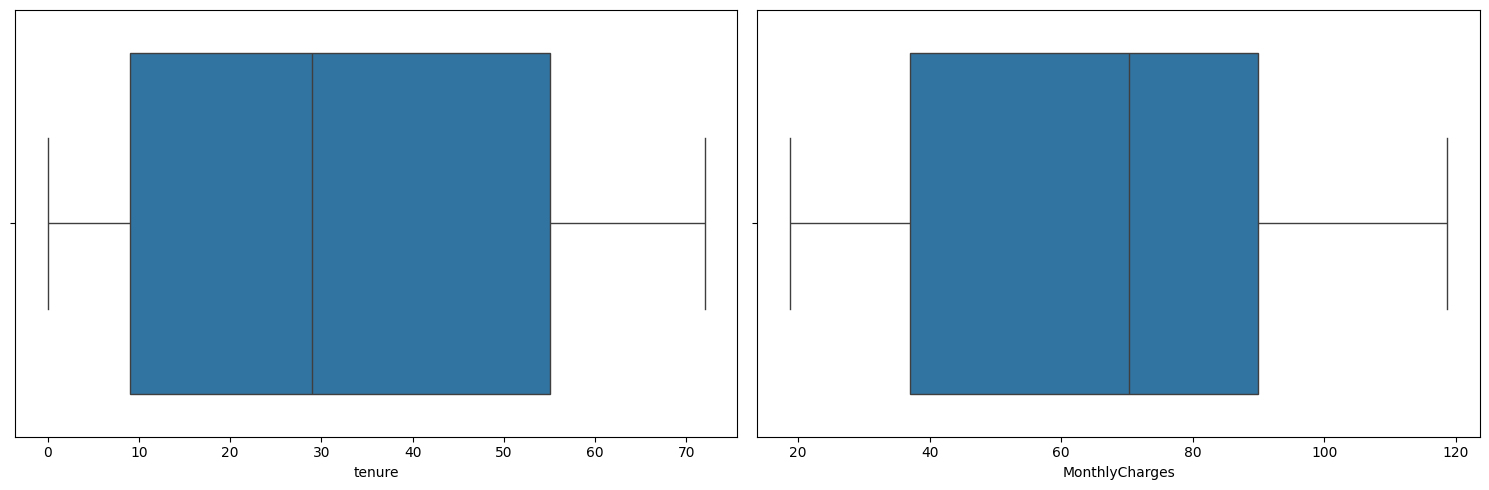

In [12]:
plt.figure(figsize = (15,5))

Pos = 1
for setiap_kolom in ChurnRaw.select_dtypes(include = 'number'):
  plt.subplot(1,2,Pos)
  sns.boxplot(x = ChurnRaw[setiap_kolom])
  Pos = Pos + 1
  plt.tight_layout()

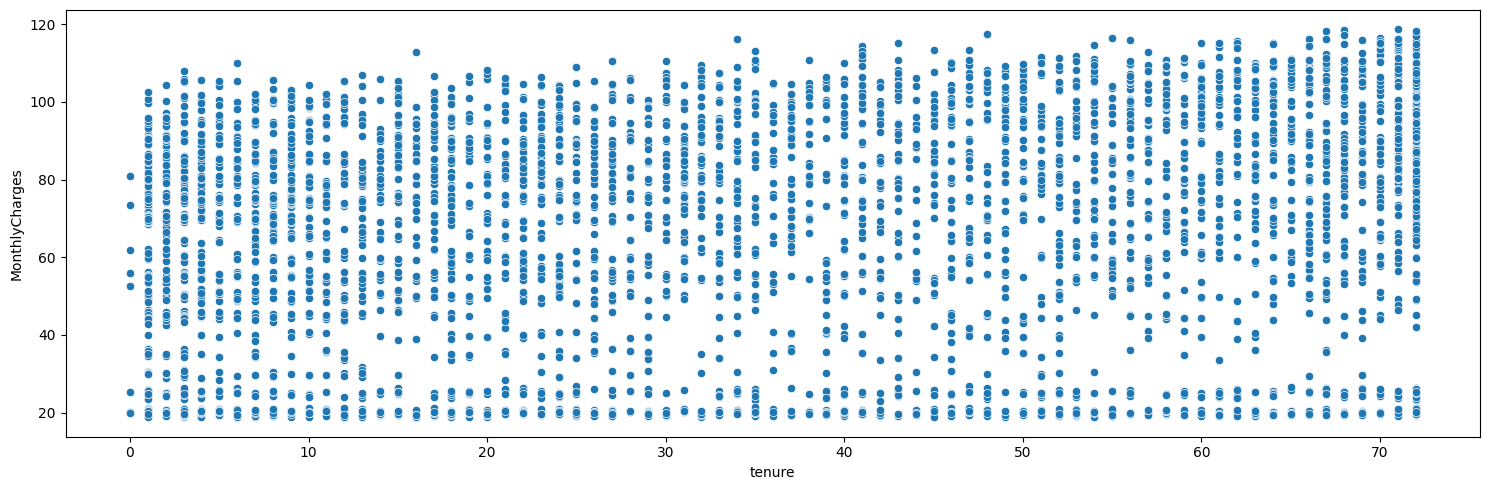

In [13]:
plt.figure(figsize = (15,5))

sns.scatterplot(x = ChurnRaw['tenure'], y = ChurnRaw['MonthlyCharges'])
plt.tight_layout()

### Isolation Forest Methodology

In [14]:
from sklearn.ensemble import IsolationForest

Iso = IsolationForest(random_state = 2023, n_estimators = 33)
IsoResult = Iso.fit_predict(ChurnRaw.select_dtypes(include = 'number'))

print(pd.Series(IsoResult).value_counts())

print(Iso.contamination)
print(Iso.n_estimators)
print(Iso.max_samples)
print(Iso.max_features)

-1    3100
 1    1830
Name: count, dtype: int64
auto
33
auto
1.0


### DBSCAN Methodology

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

Scaler = StandardScaler()
StdScaled = Scaler.fit_transform(ChurnRaw.select_dtypes(include='number'))

XDB = DBSCAN(eps=0.25, min_samples=15).fit(StdScaled)
Labels = XDB.labels_
pd.Series(Labels).value_counts()

0    4930
Name: count, dtype: int64

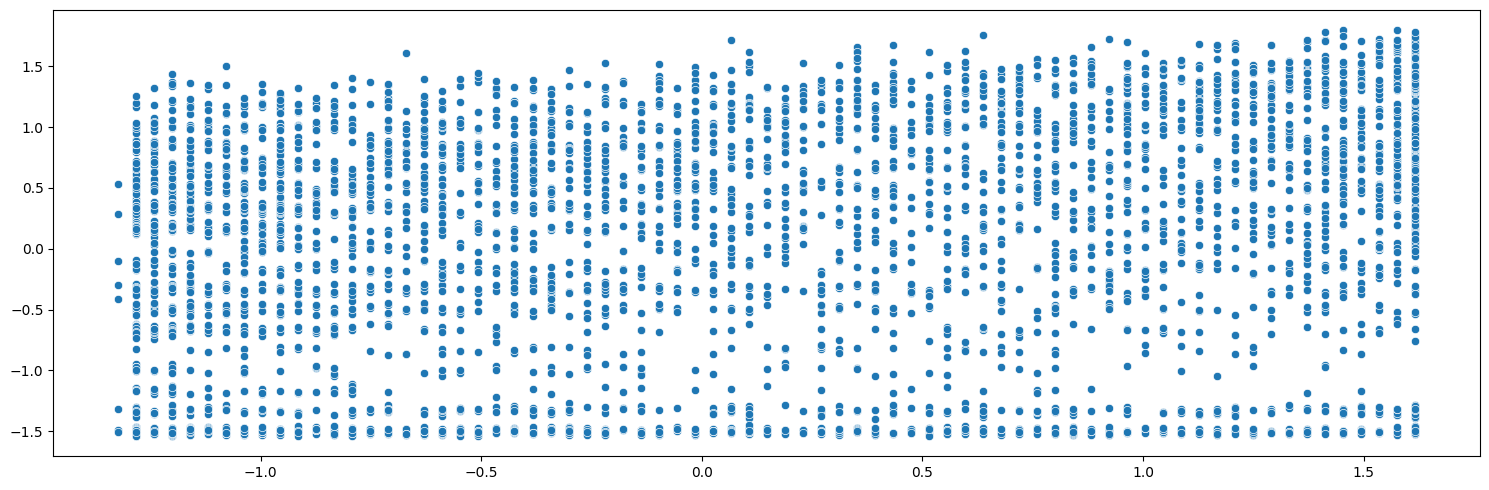

In [16]:
plt.figure(figsize = (15,5))

sns.scatterplot(x = StdScaled[:, 0], y = StdScaled[:, 1])
plt.tight_layout()

### Correlation and Collinearity

<Axes: >

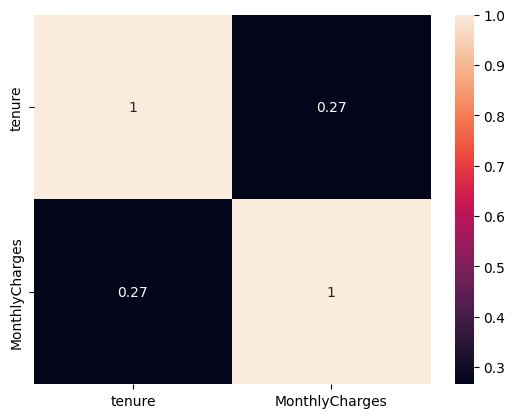

In [17]:
sns.heatmap(ChurnRaw.select_dtypes(include='number').corr(method = 'spearman'), annot = True)

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIFCalculator(X):
  VIF = pd.DataFrame()
  VIF['variables'] = X.columns
  VIF['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  return VIF

VIFCalculator(ChurnRaw.select_dtypes(include='number')).sort_values(by = 'VIF', ascending = False)

,variables,VIF
0,tenure,2.605943
1,MonthlyCharges,2.605943


## Categorical Data

In [19]:
ChurnRaw.describe(include='object')

,Dependents,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,Churn
count,4930,4930,4930,4930,4930,4930,4930,4930,4930
unique,2,3,3,3,3,3,3,2,2
top,No,No,No,Fiber optic,No,No,Month-to-month,Yes,No
freq,3446,2445,2172,2172,2186,2467,2721,2957,3614


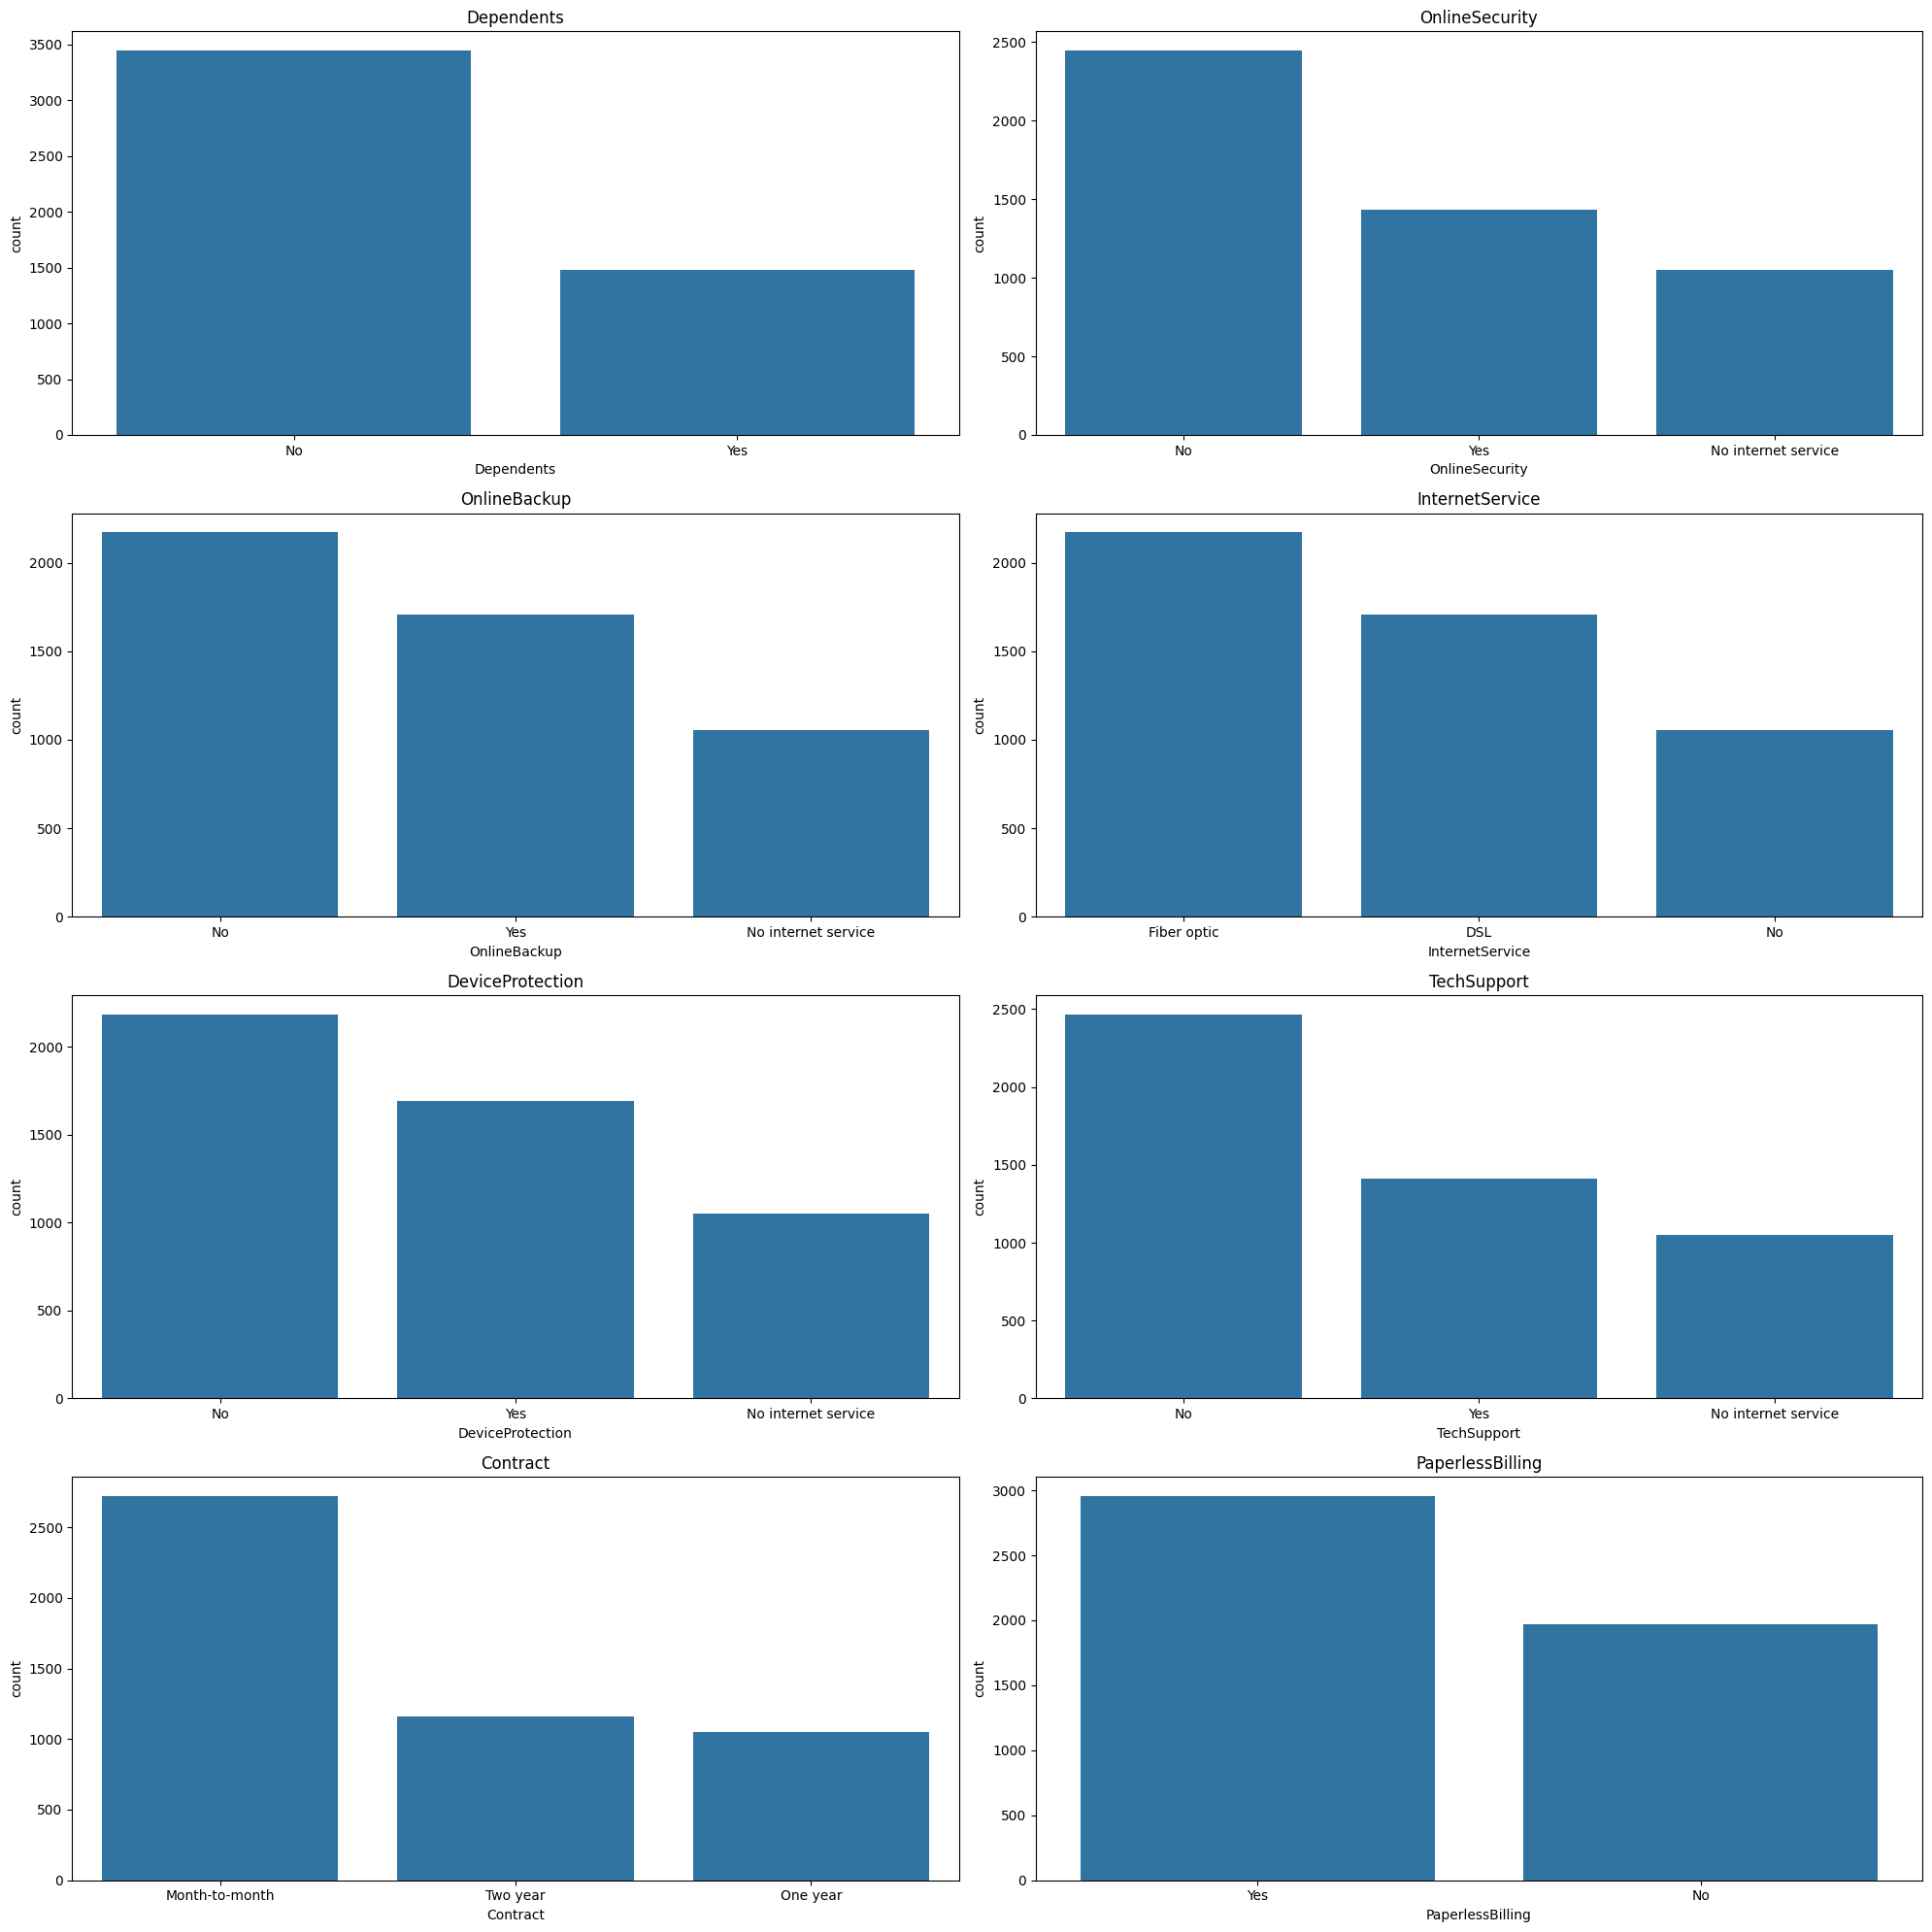

In [20]:
Checker = ChurnRaw.select_dtypes(include='object').drop(columns = 'Churn')
plt.figure(figsize = (20,20)) # (horizontal, vertikal)

Pos = 1 # menginisiasi posisi mulai dari 1
for i in Checker.columns: # kategorik.columns = nama-nama kolom dalam list
  plt.subplot(4,2,Pos)
  sns.barplot(Checker[i].value_counts().head(5))
  plt.title(i)
  Pos = Pos + 1
  plt.tight_layout()

# Modelling Phase (Taking the Data Distribution according to the IQR and DBSCAN Method...)

## Data Preparation

In [21]:
X = ChurnRaw.drop(columns = 'Churn')
Y = ChurnRaw['Churn']

In [22]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [23]:
XTrain.shape, XTest.shape, YTrain.shape, YTest.shape

((3944, 10), (986, 10), (3944,), (986,))

## Data Cleaning

- Not performed: No NaNs, no reasonably good reason to alter or delete duplicate entries (This is because there is no indication that the duplicated entries are coming from the exact same customer (i.e. no Customer IDs)) and no outliers (using IQR and DBSCAN method)

## Non-ML model

The existing rule-based model goes as follows:

In [24]:
ChurnRaw.describe()

,tenure,MonthlyCharges
count,4930.000000,4930.000000
mean,32.401217,64.883032
std,24.501193,29.923960
min,0.000000,18.800000
25%,9.000000,37.050000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.650000


In [25]:
def NonML(ChurnRaw):
  if ChurnRaw['tenure'] <= 32.401217 and ChurnRaw['MonthlyCharges'] >= 64.883032:
    return 'Yes'
  else:
    return 'No'

In [26]:
NonMLYPredTrain = XTrain.apply(NonML, axis = 1)
NonMLScoreTrain = recall_score(YTrain, NonMLYPredTrain, pos_label='Yes')

NonMLYPredTest = XTest.apply(NonML, axis = 1)
NonMLScoreTest = recall_score(YTest, NonMLYPredTest, pos_label='Yes')

In [27]:
pd.DataFrame({
    'model': ['Rule Based'],
    'train_score_mean': [NonMLScoreTrain],
    'train_score_std': None,
    'test_score': [NonMLScoreTest]})

,model,train_score_mean,train_score_std,test_score
0,Rule Based,0.539411,None,0.570342


## ML model

## Checking for balance

In [28]:
YTrain.value_counts()

Churn
No     2891
Yes    1053
Name: count, dtype: int64

## Checking most effective model

The following transformers will be applied to each column:

- OneHotEncoder for: Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, TechSupport, Contract, PaperlessBilling.
- RobustScaler for all other columns except Churn.

In [29]:
MainTransformer = ColumnTransformer([
    ('OneHot', OneHotEncoder(drop = 'first'), XTrain.drop(['tenure','MonthlyCharges'], axis=1).columns),
    ('Scaler', RobustScaler(), ['tenure','MonthlyCharges'])
], remainder = 'passthrough')
MainTransformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot', OneHotEncoder(drop='first'),
                                 Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object')),
                                ('Scaler', RobustScaler(),
                                 ['tenure', 'MonthlyCharges'])])

In [30]:
# Base Models
LogReg = LogisticRegression(max_iter = 1000)
DTC = DecisionTreeClassifier(random_state=2023)
KNN = KNeighborsClassifier()

# Voters
HardVote = VotingClassifier([
  ('LogReg', LogReg),
  ('DTC', DTC),
  ('KNN', KNN)
  ], voting = 'hard')
SoftVote = VotingClassifier([
  ('LogReg', LogReg),
  ('DTC', DTC),
  ('KNN', KNN)
  ], voting = 'soft')

# Stackers
BaseModel = ([
  ('LogReg', LogReg),
  ('DTC', DTC),
  ('KNN', KNN)
])
MetaModel = LogisticRegression(max_iter = 1000)
Stacker = StackingClassifier(BaseModel,MetaModel)

# Baggers
RFC = RandomForestClassifier(random_state=2023)

# Gradient Boosters
GBC = GradientBoostingClassifier(random_state=2023)
XGBC = XGBClassifier(random_state=2023)

In [33]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder

Relabeler = LabelEncoder()
YTrain = Relabeler.fit_transform(YTrain)
YTest = Relabeler.transform(YTest)

AllModelTrainScores = []
AllModelTrainStDev = []
AllModelTestScores = []
for i in [LogReg, DTC, KNN, HardVote, SoftVote, Stacker, RFC, GBC, XGBC]:
  Model = Pipeline([
    ('transformer', MainTransformer),
    ('model', i)
  ])

  Score = cross_val_score(Model, XTrain, YTrain, cv = StratifiedKFold(n_splits = 5), scoring = 'recall')
  AllModelTrainScores.append(Score.mean())
  AllModelTrainStDev.append(Score.std())

  Model.fit(XTrain, YTrain)
  YPredTestModelOnly = Model.predict(XTest)

  ModelTestScore = recall_score(YTest, YPredTestModelOnly)
  AllModelTestScores.append(ModelTestScore)
print(Relabeler.classes_)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


['No' 'Yes']


In [34]:
ModelRankings = pd.DataFrame({
    'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Hard', 'VC Soft', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
    'Train Scores (Mean)': AllModelTrainScores,
    'Train Scores (St. Dev)': AllModelTrainStDev,
    'Test Scores': AllModelTestScores}).sort_values(by = 'Test Scores', ascending = False)
ModelRankings

,model,Train Scores (Mean),Train Scores (St. Dev),Test Scores
8,XGBoost,0.507159,0.018834,0.574144
4,VC Soft,0.460636,0.022632,0.570342
0,Logistic Regression,0.533749,0.022189,0.555133
7,Gradient Boosting,0.523304,0.020951,0.551331
3,VC Hard,0.500555,0.036243,0.551331
5,Stacking,0.504311,0.023544,0.547529
1,Decision Tree,0.455879,0.029432,0.539924
2,KNN,0.491979,0.030378,0.494297
6,Random Forest,0.488147,0.017799,0.482890


There is close competition between the top 4, but since XGBoosting is the best, it will be used.

### Rebalancing

In [35]:
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NeighbourhoodCleaningRule, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

RUS = RandomUnderSampler(random_state=2023)
# CNN = CondensedNearestNeighbour() (NOT USED)
# NCR = NeighbourhoodCleaningRule() (NOT USED)
NM1 = NearMiss(version= 1)
NM2 = NearMiss(version= 2)
NM3 = NearMiss(version= 3)
ROS = RandomOverSampler(random_state=2023)
SMOTE = SMOTE(random_state=2023)
ADASYN = ADASYN(random_state=2023)
BLSMOTE = BorderlineSMOTE(random_state=2023)
KMSMOTE = KMeansSMOTE(random_state=2023)
SVMSMOTE = SVMSMOTE(random_state=2023)

ResamplerTrainScores = []
ResamplerTrainStDev = []
ResamplerTestScores = []

for sampler in [RUS, NM1, NM2, NM3, ROS, SMOTE, ADASYN, BLSMOTE, KMSMOTE, SVMSMOTE]:

  Model = Pipeline([
    ('transformer', MainTransformer),
    ('resampler', sampler),
    ('model', XGBC)
  ])

  Score = cross_val_score(Model, XTrain, YTrain, cv = StratifiedKFold(n_splits = 5), scoring = 'recall')
  ResamplerTrainScores.append(Score.mean())
  ResamplerTrainStDev.append(Score.std())

  Model.fit(XTrain, YTrain)
  YPredTest = Model.predict(XTest)
  TestScore = recall_score(YTest, YPredTest)

  ResamplerTestScores.append(TestScore)

Condensed Nearest Neighbour and Neighbourhood Cleaning Rule are not used for the sake of time.

In [36]:
SamplingRankings = pd.DataFrame(
    {'metode': [RUS, NM1, NM2, NM3, ROS, SMOTE, ADASYN, BLSMOTE, KMSMOTE, SVMSMOTE],
    'Train Scores (Mean)': ResamplerTrainScores,
    'Train Scores (St. Dev)': ResamplerTrainStDev,
    'Test Scores': ResamplerTestScores}
)
SamplingRankings.sort_values(by = 'Test Scores', ascending = False)

,metode,Train Scores (Mean),Train Scores (St. Dev),Test Scores
0,RandomUnderSampler(random_state=2023),0.745502,0.031321,0.798479
7,BorderlineSMOTE(random_state=2023),0.677161,0.026435,0.745247
9,SVMSMOTE(random_state=2023),0.663859,0.023541,0.726236
4,RandomOverSampler(random_state=2023),0.643931,0.041079,0.722433
6,ADASYN(random_state=2023),0.669573,0.028708,0.722433
5,SMOTE(random_state=2023),0.646752,0.028215,0.707224
2,NearMiss(version=2),0.694236,0.030378,0.703422
8,KMeansSMOTE(random_state=2023),0.586947,0.034379,0.661597
1,NearMiss(),0.642965,0.049887,0.631179
3,NearMiss(version=3),0.577454,0.039217,0.631179


## Testing for Optimal Hyperparameters

In [37]:
from sklearn.model_selection import GridSearchCV

Model = Pipeline([
  ('transformer', MainTransformer),
  ('resampler', RUS),
  ('model', XGBC)
])

ParameterTest = {
  'model__max_depth': [4,5,6],
  'model__min_child_weight': [1,2,3],
  'model__gamma': [0,1,2],
  'model__reg_alpha': [0,1,2],
  'model__reg_lambda': [0,1,2],
  'model__learning_rate': [0.001,0.01,0.1],
  'model__n_estimators': [100,200,300]
}

GridSearch = GridSearchCV(
  estimator = Model,
  param_grid = ParameterTest,
  scoring = 'recall',
  cv = StratifiedKFold(5),
  n_jobs = -1,
  verbose = 3
)

In [38]:
GridSearch.fit(XTrain, YTrain)

Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OneHot',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype...
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=2023, ...))]),
             n_jobs=-1,
             param_grid={'model__gamma': [0, 1, 2],
                         'model__learning_rate': [0.001, 0.01, 0.1],
                         'model__max_depth': [4, 5, 6],
                         'model__min_child_weight': [1, 2, 3],
                         'model__n_estimators': [100, 200, 300],
                         'model__reg_alpha': [0, 1, 2],
                         'model__reg_lambda': [0, 1, 2]},
             scoring='recall', verbose=3)

In [39]:
GridSearch.best_params_

{'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': 6,
 'model__min_child_weight': 1,
 'model__n_estimators': 200,
 'model__reg_alpha': 0,
 'model__reg_lambda': 1}

Optimal model: {'model__gamma': 0,
 'model__learning_rate': 0.01,
 'model__max_depth': 6,
 'model__min_child_weight': 1,
 'model__n_estimators': 200,
 'model__reg_alpha': 0,
 'model__reg_lambda': 1}

In [40]:
GridSearch.best_score_

np.float64(0.8063055743624463)

In [41]:
pd.DataFrame(GridSearch.cv_results_).sort_values(by = 'rank_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__min_child_weight,param_model__n_estimators,param_model__reg_alpha,param_model__reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
696,0.211543,0.001538,0.018282,0.001283,0,0.10,6,2,300,1,0,"{'model__gamma': 0, 'model__learning_rate': 0....",0.752381,0.734597,0.706161,0.772512,0.757143,0.744559,0.022692,2187
666,0.217418,0.017571,0.017753,0.000977,0,0.10,6,1,300,0,0,"{'model__gamma': 0, 'model__learning_rate': 0....",0.761905,0.729858,0.706161,0.758294,0.766667,0.744577,0.023103,2186
585,0.174433,0.006480,0.015508,0.000457,0,0.10,5,1,300,0,0,"{'model__gamma': 0, 'model__learning_rate': 0....",0.780952,0.753555,0.706161,0.767773,0.733333,0.748355,0.026354,2185
669,0.274371,0.049545,0.018351,0.001492,0,0.10,6,1,300,1,0,"{'model__gamma': 0, 'model__learning_rate': 0....",0.761905,0.748815,0.701422,0.781991,0.752381,0.749303,0.026569,2184
693,0.193323,0.006440,0.018230,0.001315,0,0.10,6,2,300,0,0,"{'model__gamma': 0, 'model__learning_rate': 0....",0.795238,0.753555,0.696682,0.772512,0.738095,0.751216,0.033296,2183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.279054,0.028253,0.017951,0.001669,0,0.01,6,1,300,0,1,"{'model__gamma': 0, 'model__learning_rate': 0....",0.814286,0.800948,0.786730,0.796209,0.823810,0.804396,0.013158,4
981,0.137886,0.021364,0.014960,0.001669,1,0.01,4,1,200,0,0,"{'model__gamma': 1, 'model__learning_rate': 0....",0.800000,0.791469,0.791469,0.800948,0.838095,0.804396,0.017327,4
307,0.117029,0.016276,0.014896,0.002819,0,0.01,4,3,200,0,1,"{'model__gamma': 0, 'model__learning_rate': 0....",0.804762,0.781991,0.781991,0.810427,0.842857,0.804405,0.022449,3
1197,0.160686,0.007249,0.014769,0.000234,1,0.01,6,3,200,0,0,"{'model__gamma': 1, 'model__learning_rate': 0....",0.814286,0.800948,0.796209,0.777251,0.838095,0.805358,0.020222,2


In [42]:
OptimalModel = Pipeline([
  ('transformer', MainTransformer),
  ('resampler', RUS),
  ('model', XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023))
])
OptimalModel.fit(XTrain, YTrain)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object')),
                                                 ('Scaler', RobustScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('resampler', Rand...
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=2023, ...))])

## Checking Feature Importance

In [43]:
Importance = OptimalModel.named_steps['model'].feature_importances_
Features = OptimalModel.named_steps['transformer'].get_feature_names_out()

FeatImpRank = pd.DataFrame({
  'Features': Features,
  'Importance': Importance
}).sort_values(by = 'Importance', ascending = False)
FeatImpRank

,Features,Importance
12,OneHot__Contract_Two year,0.352929
11,OneHot__Contract_One year,0.261532
5,OneHot__InternetService_Fiber optic,0.238376
14,Scaler__tenure,0.032003
1,OneHot__OnlineSecurity_No internet service,0.024321
0,OneHot__Dependents_Yes,0.016213
4,OneHot__OnlineBackup_Yes,0.014688
15,Scaler__MonthlyCharges,0.014685
2,OneHot__OnlineSecurity_Yes,0.013292
13,OneHot__PaperlessBilling_Yes,0.012931


### RFE

In [44]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

RecallTrainList = []
RecallTestList = []

for i in range(1,15):
  OptimalModel = Pipeline([
    ('transformer', MainTransformer),
    ('resampler', RUS),
    ('selector', RFE((XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023)), n_features_to_select = i)),
    ('model', XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023))
  ])
  OptimalModel.fit(XTrain, YTrain)

  YPredTrain = OptimalModel.predict(XTrain)
  YPredTest = OptimalModel.predict(XTest)

  RecallTrain = recall_score(YTrain, YPredTrain)
  RecallTrainList.append(RecallTrain)
  RecallTest = recall_score(YTest, YPredTest)
  RecallTestList.append(RecallTest)

RecallScores = pd.DataFrame({'k': np.arange(1,15),
  'RecallTrain': RecallTrainList,
  'RecallTest': RecallTestList
  })
RecallScores.sort_values(by = 'RecallTest', ascending = False)

,k,RecallTrain,RecallTest
0,1,0.970560,0.996198
1,2,0.888889,0.920152
2,3,0.888889,0.920152
3,4,0.831909,0.874525
12,13,0.856600,0.828897
13,14,0.856600,0.828897
11,12,0.856600,0.828897
10,11,0.854701,0.828897
8,9,0.851852,0.817490
9,10,0.846154,0.817490


### SFS

In [45]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

RecallTrainListSFS = []
RecallTestListSFS = []

for i in range(1,15):
  OptimalModelSFS = Pipeline([
    ('transformer', MainTransformer),
    ('resampler', RUS),
    ('selector', SequentialFeatureSelector(XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023), n_features_to_select = i)),
    ('model', XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023))
  ])
  OptimalModelSFS.fit(XTrain, YTrain)

  YPredTrainSFS = OptimalModelSFS.predict(XTrain)
  YPredTestSFS = OptimalModelSFS.predict(XTest)

  RecallTrainSFS = recall_score(YTrain, YPredTrainSFS)
  RecallTrainListSFS.append(RecallTrainSFS)
  RecallTestSFS = recall_score(YTest, YPredTestSFS)
  RecallTestListSFS.append(RecallTestSFS)

RecallScoresSFS = pd.DataFrame({'k': np.arange(1,15),
  'RecallTrain': RecallTrainListSFS,
  'RecallTest': RecallTestListSFS
  })
RecallScoresSFS.sort_values(by = 'RecallTest', ascending = False)

,k,RecallTrain,RecallTest
13,14,0.827160,0.825095
10,11,0.822412,0.817490
7,8,0.822412,0.817490
8,9,0.822412,0.817490
6,7,0.822412,0.817490
9,10,0.822412,0.817490
11,12,0.822412,0.817490
12,13,0.821462,0.817490
4,5,0.792972,0.798479
3,4,0.796771,0.787072


# Modelling Phase (Taking the Data Distribution according to the Isolation Forest Method...)

## Data Cleaning and Preparation

In [46]:
OutlierIndices = np.where(IsoResult == -1)
ChurnIso = ChurnRaw.drop(OutlierIndices[0], axis=0)

In [47]:
X = ChurnIso.drop(columns = 'Churn')
Y = ChurnIso['Churn']

In [48]:
XTrainIso, XTestIso, YTrainIso, YTestIso = train_test_split(X, Y, test_size = 0.2, random_state = 42, stratify = Y)

In [49]:
XTrainIso.shape, XTestIso.shape, YTrainIso.shape, YTestIso.shape

((1464, 10), (366, 10), (1464,), (366,))

## Non-ML model

The existing rule-based model goes as follows:

In [50]:
ChurnIso.describe()

,tenure,MonthlyCharges
count,1830.000000,1830.000000
mean,20.170492,72.572268
std,18.849361,21.629997
min,1.000000,19.600000
25%,4.000000,68.962500
50%,12.000000,77.975000
75%,34.000000,85.850000
max,67.000000,106.600000


In [51]:
def NonMLIso(ChurnIso):
  if ChurnIso['tenure'] <= 20.170492 and ChurnIso['MonthlyCharges'] >= 72.572268:
    return 'Yes'
  else:
    return 'No'

In [52]:
NonMLYPredTrainIso = XTrainIso.apply(NonMLIso, axis = 1)
NonMLScoreTrainIso = recall_score(YTrainIso, NonMLYPredTrainIso, pos_label='Yes')

NonMLYPredTestIso = XTestIso.apply(NonMLIso, axis = 1)
NonMLScoreTestIso = recall_score(YTestIso, NonMLYPredTestIso, pos_label='Yes')

In [53]:
pd.DataFrame({
  'model': ['Rule Based'],
  'train_score_mean': [NonMLScoreTrainIso],
  'train_score_std': None,
  'test_score': [NonMLScoreTestIso]})

,model,train_score_mean,train_score_std,test_score
0,Rule Based,0.449153,None,0.455782


## ML model

## Checking for balance

In [54]:
YTrainIso.value_counts()

Churn
No     874
Yes    590
Name: count, dtype: int64

## Checking most effective model

The following transformers will be applied to each column:

- OneHotEncoder for: Dependents, OnlineSecurity, OnlineBackup, InternetService, DeviceProtection, TechSupport, TechSupport, Contract, PaperlessBilling.
- RobustScaler for all other columns except Churn.

In [55]:
MainTransformer = ColumnTransformer([
  ('OneHot', OneHotEncoder(drop = 'first'), XTrain.drop(['tenure','MonthlyCharges'], axis=1).columns),
  ('Scaler', RobustScaler(), ['tenure','MonthlyCharges'])
], remainder = 'passthrough')
MainTransformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('OneHot', OneHotEncoder(drop='first'),
                                 Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object')),
                                ('Scaler', RobustScaler(),
                                 ['tenure', 'MonthlyCharges'])])

In [56]:
# Base Models
LogReg = LogisticRegression(max_iter = 1000)
DTC = DecisionTreeClassifier(random_state=2023)
KNN = KNeighborsClassifier()

# Voters
HardVote = VotingClassifier([
  ('LogReg', LogReg),
  ('DTC', DTC),
  ('KNN', KNN)
  ], voting = 'hard')
SoftVote = VotingClassifier([
  ('LogReg', LogReg),
  ('DTC', DTC),
  ('KNN', KNN)
  ], voting = 'soft')

# Stackers
BaseModel = ([
  ('LogReg', LogReg),
  ('DTC', DTC),
  ('KNN', KNN)
])
MetaModel = LogisticRegression(max_iter = 1000)
Stacker = StackingClassifier(BaseModel,MetaModel)

# Baggers
RFC = RandomForestClassifier(random_state=2023)

# Gradient Boosters
GBC = GradientBoostingClassifier(random_state=2023)
XGBC = XGBClassifier(random_state=2023)

In [57]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder

Relabeler = LabelEncoder()
YTrainIso = Relabeler.fit_transform(YTrainIso)
YTestIso = Relabeler.transform(YTestIso)

AllModelTrainScoresIso = []
AllModelTrainStDevIso = []
AllModelTestScoresIso = []
for i in [LogReg, DTC, KNN, HardVote, SoftVote, Stacker, RFC, GBC, XGBC]:
  ModelIso = Pipeline([
    ('transformer', MainTransformer),
    ('model', i)
  ])

  ScoreIso = cross_val_score(ModelIso, XTrainIso, YTrainIso, cv = StratifiedKFold(n_splits = 5), scoring = 'recall')
  AllModelTrainScoresIso.append(ScoreIso.mean())
  AllModelTrainStDevIso.append(ScoreIso.std())

  ModelIso.fit(XTrainIso, YTrainIso)
  YPredTestModelOnlyIso = ModelIso.predict(XTestIso)

  ModelTestScoreIso = recall_score(YTestIso, YPredTestModelOnlyIso)
  AllModelTestScoresIso.append(ModelTestScoreIso)
print(Relabeler.classes_)

['No' 'Yes']


In [58]:
ModelRankingsIso = pd.DataFrame({
  'model': ['Logistic Regression', 'Decision Tree', 'KNN', 'VC Hard', 'VC Soft', 'Stacking', 'Random Forest', 'Gradient Boosting', 'XGBoost'],
  'Train Scores (Mean)': AllModelTrainScoresIso,
  'Train Scores (St. Dev)': AllModelTrainStDevIso,
  'Test Scores': AllModelTestScoresIso}).sort_values(by = 'Test Scores', ascending = False)
ModelRankingsIso

,model,Train Scores (Mean),Train Scores (St. Dev),Test Scores
0,Logistic Regression,0.600000,0.024208,0.598639
3,VC Hard,0.588136,0.041378,0.591837
7,Gradient Boosting,0.601695,0.053865,0.578231
5,Stacking,0.596610,0.042067,0.571429
2,KNN,0.547458,0.043411,0.564626
4,VC Soft,0.579661,0.030602,0.544218
6,Random Forest,0.547458,0.053221,0.530612
1,Decision Tree,0.577966,0.039894,0.523810
8,XGBoost,0.561017,0.047458,0.517007


### Rebalancing

In [59]:
from imblearn.under_sampling import RandomUnderSampler, CondensedNearestNeighbour, NeighbourhoodCleaningRule, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE

RUS = RandomUnderSampler(random_state=2023)
# CNN = CondensedNearestNeighbour() (NOT USED)
# NCR = NeighbourhoodCleaningRule() (NOT USED)
NM1 = NearMiss(version= 1)
NM2 = NearMiss(version= 2)
NM3 = NearMiss(version= 3)
ROS = RandomOverSampler(random_state=2023)
SMOTE = SMOTE(random_state=2023)
ADASYN = ADASYN(random_state=2023)
BLSMOTE = BorderlineSMOTE(random_state=2023)
KMSMOTE = KMeansSMOTE(random_state=2023)
SVMSMOTE = SVMSMOTE(random_state=2023)

ResamplerTrainScoresIso = []
ResamplerTrainStDevIso = []
ResamplerTestScoresIso = []

for sampler in [RUS, NM1, NM2, NM3, ROS, SMOTE, ADASYN, BLSMOTE, KMSMOTE, SVMSMOTE]:

  ModelIso = Pipeline([
    ('transformer', MainTransformer),
    ('resampler', sampler),
    ('model', LogReg)
  ])

  ScoreIso = cross_val_score(ModelIso, XTrainIso, YTrainIso, cv = StratifiedKFold(n_splits = 5), scoring = 'recall')
  ResamplerTrainScoresIso.append(ScoreIso.mean())
  ResamplerTrainStDevIso.append(ScoreIso.std())

  ModelIso.fit(XTrainIso, YTrainIso)
  YPredTestIso = ModelIso.predict(XTestIso)
  TestScoreIso = recall_score(YTestIso, YPredTestIso)

  ResamplerTestScoresIso.append(TestScoreIso)

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:203: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(
c:\Users\user\AppData\Loc

Condensed Nearest Neighbour and Neighbourhood Cleaning Rule are not used for the sake of time.

In [60]:
SamplingRankingsIso = pd.DataFrame(
  {'metode': [RUS, NM1, NM2, NM3, ROS, SMOTE, ADASYN, BLSMOTE, KMSMOTE, SVMSMOTE],
  'Train Scores (Mean)': ResamplerTrainScoresIso,
  'Train Scores (St. Dev)': ResamplerTrainStDevIso,
  'Test Scores': ResamplerTestScoresIso}
)
SamplingRankingsIso.sort_values(by = 'Test Scores', ascending = False)

,metode,Train Scores (Mean),Train Scores (St. Dev),Test Scores
6,ADASYN(random_state=2023),0.747458,0.030976,0.734694
9,SVMSMOTE(random_state=2023),0.735593,0.045289,0.727891
7,BorderlineSMOTE(random_state=2023),0.740678,0.031527,0.721088
2,NearMiss(version=2),0.740678,0.046602,0.714286
4,RandomOverSampler(random_state=2023),0.733898,0.043741,0.714286
5,SMOTE(random_state=2023),0.723729,0.039240,0.700680
0,RandomUnderSampler(random_state=2023),0.723729,0.042407,0.687075
3,NearMiss(version=3),0.689831,0.029160,0.680272
8,KMeansSMOTE(random_state=2023),0.684746,0.040959,0.673469
1,NearMiss(),0.654237,0.030034,0.666667


## Testing for Optimal Hyperparameters

In [61]:
from sklearn.model_selection import GridSearchCV

ModelIso = Pipeline([
  ('transformer', MainTransformer),
  ('resampler', ADASYN),
  ('model', LogReg)
])

ParameterTest = {
  'model__penalty': ['l1'],
  'model__solver': ['liblinear','saga'],
  'model__max_iter': [100,1000,3333],
  'model__C': [0.01,0.1,1,10,100]
}

GridSearchIso = GridSearchCV(
  estimator = ModelIso,
  param_grid = ParameterTest,
  scoring = 'recall',
  cv = StratifiedKFold(5),
  n_jobs = -1,
  verbose = 3
)

In [62]:
GridSearchIso.fit(XTrainIso, YTrainIso)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OneHot',
                                                                         OneHotEncoder(drop='first'),
                                                                         Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object')),
                                                                        ('Scaler',
                                                                         RobustScaler(),
                                                                         ['tenure',
                                                                          'MonthlyCharges'])])),
                                       ('resampler', ADASYN(random_state=2023)),
                                       ('model',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__max_iter': [100, 1000, 3333],
                         'model__penalty': ['l1'],
                         'model__solver': ['liblinear', 'saga']},
             scoring='recall', verbose=3)

In [63]:
GridSearchIso.best_params_

{'model__C': 10,
 'model__max_iter': 100,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

Optimal model: {'model__C': 10,
 'model__max_iter': 100,
 'model__penalty': 'l1',
 'model__solver': 'saga'}

In [64]:
GridSearchIso.best_score_

np.float64(0.7491525423728814)

In [65]:
pd.DataFrame(GridSearchIso.cv_results_).sort_values(by = 'rank_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__max_iter,param_model__penalty,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.047551,0.039309,0.012894,0.003872,0.01,100,l1,liblinear,"{'model__C': 0.01, 'model__max_iter': 100, 'mo...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27
2,0.032860,0.005285,0.010388,0.001241,0.01,1000,l1,liblinear,"{'model__C': 0.01, 'model__max_iter': 1000, 'm...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27
5,0.036172,0.008368,0.010799,0.005237,0.01,3333,l1,saga,"{'model__C': 0.01, 'model__max_iter': 3333, 'm...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27
4,0.027299,0.005505,0.013128,0.009687,0.01,3333,l1,liblinear,"{'model__C': 0.01, 'model__max_iter': 3333, 'm...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27
1,0.032732,0.003896,0.011298,0.002237,0.01,100,l1,saga,"{'model__C': 0.01, 'model__max_iter': 100, 'mo...",0.000000,0.000000,0.000000,1.000000,0.000000,0.200000,0.400000,25
3,0.032745,0.005517,0.016013,0.011445,0.01,1000,l1,saga,"{'model__C': 0.01, 'model__max_iter': 1000, 'm...",0.000000,1.000000,0.000000,0.000000,0.000000,0.200000,0.400000,25
6,0.058631,0.051135,0.008400,0.002061,0.10,100,l1,liblinear,"{'model__C': 0.1, 'model__max_iter': 100, 'mod...",0.669492,0.694915,0.728814,0.737288,0.652542,0.696610,0.032778,19
7,0.088624,0.065792,0.011569,0.002240,0.10,100,l1,saga,"{'model__C': 0.1, 'model__max_iter': 100, 'mod...",0.652542,0.694915,0.720339,0.745763,0.669492,0.696610,0.033643,19
8,0.105807,0.065232,0.008777,0.000399,0.10,1000,l1,liblinear,"{'model__C': 0.1, 'model__max_iter': 1000, 'mo...",0.669492,0.694915,0.728814,0.737288,0.652542,0.696610,0.032778,19
9,0.088424,0.065977,0.011569,0.002570,0.10,1000,l1,saga,"{'model__C': 0.1, 'model__max_iter': 1000, 'mo...",0.652542,0.694915,0.720339,0.745763,0.669492,0.696610,0.033643,19


In [66]:
OptimalModelIso = Pipeline([
  ('transformer', MainTransformer),
  ('resampler', ADASYN),
  ('model', LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023))
])
OptimalModelIso.fit(XTrain, YTrain)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OneHot',
                                                  OneHotEncoder(drop='first'),
                                                  Index(['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService',
       'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object')),
                                                 ('Scaler', RobustScaler(),
                                                  ['tenure',
                                                   'MonthlyCharges'])])),
                ('resampler', ADASYN(random_state=2023)),
                ('model',
                 LogisticRegression(C=10, penalty='l1', random_state=2023,
                                    solver='saga'))])

## Checking Feature Importance

### RFE

In [67]:
ImportanceIso = OptimalModelIso.named_steps['model'].coef_[0]
FeaturesIso = OptimalModelIso.named_steps['transformer'].get_feature_names_out()

print(f"Shape of Features: {FeaturesIso.shape}")
print(f"Shape of Importance: {ImportanceIso.shape}")

FeatImpRankIso = pd.DataFrame({
  'Features': FeaturesIso,
  'Importance': ImportanceIso
}).sort_values(by = 'Importance', ascending = False)
FeatImpRankIso

Shape of Features: (16,)
Shape of Importance: (16,)


,Features,Importance
15,Scaler__MonthlyCharges,1.230643
13,OneHot__PaperlessBilling_Yes,0.406097
5,OneHot__InternetService_Fiber optic,0.000075
8,OneHot__DeviceProtection_Yes,-0.030831
7,OneHot__DeviceProtection_No internet service,-0.081078
1,OneHot__OnlineSecurity_No internet service,-0.081078
6,OneHot__InternetService_No,-0.081078
3,OneHot__OnlineBackup_No internet service,-0.081078
9,OneHot__TechSupport_No internet service,-0.081078
4,OneHot__OnlineBackup_Yes,-0.171465


In [68]:
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score

RecallTrainListIso = []
RecallTestListIso = []

for i in range(1,15):
  OptimalModelIso = Pipeline([
    ('transformer', MainTransformer),
    ('resampler', ADASYN),
    ('selector', RFE(LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023), n_features_to_select = i)),
    ('model', LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023))
  ])
  OptimalModelIso.fit(XTrainIso, YTrainIso)

  YPredTrainIso = OptimalModelIso.predict(XTrainIso)
  YPredTestIso = OptimalModelIso.predict(XTestIso)

  RecallTrainIso = recall_score(YTrainIso, YPredTrainIso)
  RecallTrainListIso.append(RecallTrainIso)
  RecallTestIso = recall_score(YTestIso, YPredTestIso)
  RecallTestListIso.append(RecallTestIso)

RecallScoresIso = pd.DataFrame({'k': np.arange(1,15),
  'RecallTrain': RecallTrainListIso,
  'RecallTest': RecallTestListIso
  })
RecallScoresIso.sort_values(by = 'RecallTest', ascending = False)

,k,RecallTrain,RecallTest
0,1,0.994915,0.993197
1,2,0.935593,0.945578
10,11,0.755932,0.741497
11,12,0.755932,0.741497
8,9,0.761017,0.741497
2,3,0.774576,0.734694
12,13,0.757627,0.734694
13,14,0.757627,0.734694
9,10,0.757627,0.734694
5,6,0.715254,0.721088


In [69]:
SelectedFeaturesIso = OptimalModelIso.named_steps['selector'].support_
print(SelectedFeaturesIso)

[ True False  True False  True  True  True  True  True  True  True  True
  True  True  True  True]


### SFS

In [70]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import accuracy_score

RecallTrainListIsoSFS = []
RecallTestListIsoSFS = []

for i in range(1,15):
  OptimalModelIsoSFS = Pipeline([
    ('transformer', MainTransformer),
    ('resampler', ADASYN),
    ('selector', SequentialFeatureSelector(LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023), n_features_to_select = i)),
    ('model', LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023))
  ])
  OptimalModelIsoSFS.fit(XTrainIso, YTrainIso)

  YPredTrainIsoSFS = OptimalModelIsoSFS.predict(XTrainIso)
  YPredTestIsoSFS = OptimalModelIsoSFS.predict(XTestIso)

  RecallTrainSFSIso = recall_score(YTrainIso, YPredTrainIsoSFS)
  RecallTrainListIsoSFS.append(RecallTrainSFSIso)
  RecallTestSFSIso = recall_score(YTestIso, YPredTestIsoSFS)
  RecallTestListIsoSFS.append(RecallTestSFSIso)

RecallScoresIsoSFS = pd.DataFrame({'k': np.arange(1,15),
    'RecallTrain': RecallTrainListIsoSFS,
    'RecallTest': RecallTestListIsoSFS
    })
RecallScoresIsoSFS.sort_values(by = 'RecallTest', ascending = False)

,k,RecallTrain,RecallTest
0,1,0.813559,0.761905
12,13,0.803390,0.748299
10,11,0.803390,0.748299
11,12,0.803390,0.748299
8,9,0.803390,0.748299
9,10,0.803390,0.748299
13,14,0.803390,0.748299
1,2,0.779661,0.741497
7,8,0.779661,0.727891
5,6,0.757627,0.714286


# Which will be the Final Model?

In [71]:
FinalModel = Pipeline([
  ('transformer', MainTransformer),
  ('resampler', RUS),
  ('selector', RFE((XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023)), n_features_to_select = 1)),
  ('model', XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1, random_state=2023))
])
FinalScore = cross_val_score(FinalModel, XTrain, YTrain, cv = StratifiedKFold(n_splits = 5), scoring = 'recall')

FinalModel.fit(XTrain, YTrain)

FinalYPredTest = FinalModel.predict(XTest)
FinalRecallTest = recall_score(YTest, FinalYPredTest)

FinalModelIso = Pipeline([
  ('transformer', MainTransformer),
  ('resampler', ADASYN),
  ('selector', RFE(LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023), n_features_to_select = 1)),
  ('model', LogisticRegression(C=10, max_iter=100, penalty='l1', solver='saga', random_state=2023))
])
FinalScoreIso = cross_val_score(FinalModelIso, XTrainIso, YTrainIso, cv = StratifiedKFold(n_splits = 5), scoring = 'recall')

FinalModelIso.fit(XTrainIso, YTrainIso)

FinalYPredTestIso = FinalModelIso.predict(XTestIso)
FinalRecallTestIso = recall_score(YTestIso, FinalYPredTestIso)

FinalRanking = pd.DataFrame({
  'Outlier Detection Method': ['IQR/DBSCAN', 'Isolation Forest'],
  'Test Scores': [FinalRecallTest, FinalRecallTestIso]}).sort_values(by = 'Test Scores', ascending = False)
FinalRanking

,Outlier Detection Method,Test Scores
0,IQR/DBSCAN,0.996198
1,Isolation Forest,0.993197


It is very close, but we get 99.6% recall if we follow the IQR/DBSCAN detection of outliers (i.e. no outliers). This will be the final model.

The most important features in the IQR/DBSCAN model are as follows:

In [72]:
SelectedFeatures = FinalModel.named_steps['selector'].support_
print(SelectedFeatures)

[False False False False False False False False False False False False
  True False False False]


In [73]:
FeatImpRank = pd.DataFrame({
  'Features': Features,
  'Importance': Importance
}).sort_values(by = 'Importance', ascending = False)
FeatImpRank

,Features,Importance
12,OneHot__Contract_Two year,0.352929
11,OneHot__Contract_One year,0.261532
5,OneHot__InternetService_Fiber optic,0.238376
14,Scaler__tenure,0.032003
1,OneHot__OnlineSecurity_No internet service,0.024321
0,OneHot__Dependents_Yes,0.016213
4,OneHot__OnlineBackup_Yes,0.014688
15,Scaler__MonthlyCharges,0.014685
2,OneHot__OnlineSecurity_Yes,0.013292
13,OneHot__PaperlessBilling_Yes,0.012931


<Axes: xlabel='Importance', ylabel='Features'>

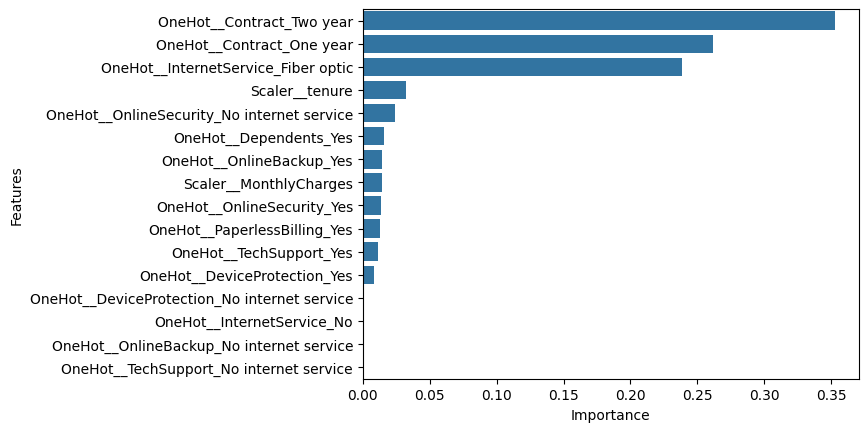

In [74]:
sns.barplot(x = 'Importance', y = 'Features', data = FeatImpRank)

The one 'True' in this result corresponds to 'OneHot__Contract_Two year', i.e. the model looks at whether the contract is for two years in order to declare if the customer is at risk of churning or not.

It could be that two years with our product is such a long time that, by the time the contract ends, the state of the company might be so different that, somewhere in the middle of that contract, the product might no longer serves them well, but since they are obligated to use the product since the contract is still active, it starts building frustration and bad rapport with our business, which lowers their view of our product and chances to re-subscribe. Or it might not - the direction of which churn tends to go cannot be seen in XGBoost models.

## Explanation of Model Functionality

This is a model that uses supervised learning in order to predict which customers are at risk of churning.

The model is made up of:

- The transformer:
 - The categorical data is run through a OneHotEncoder to convert it into numerical data. This Encoder is used as there are few categories per column for all of the categoricla data available.
 - The numerical data is run through a RobustScaler due to its non-normal distribution.
- The resampler, RandomUnderSampler, randomly deletes data from the majority category in order to balance the training data for all categories. (Source: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/.
- The model, XGBoost Classifier, is an ensemble method that combines the prediction of multiple decision trees trained via gradient boosting to make a strong prediction (Source: https://apmonitor.com/pds/index.php/Main/XGBoostClassifier)


## Limitations of Model

The limits of the numerical data used for this model are as follows:

| Feature | Range |
|---|---|
| Tenure | 0 - 72 months |
| MonthlyCharges | 18.8 - 118.65 |

The categorical data in the Dataframe only take into account the following categories:

| Feature | Range |
|---|---|
| Dependents | Y/N |
| OnlineSecurity | Y/N/No Internet Service |
| OnlineBackup | Y/N/No Internet Service |
| InternetService | DSL/Fiber Optic/No |
| DeviceProtection | Y/N/No Internet Service |
| TechSupport | Y/N/No Internet Service |
| Contract | Month-to-month/One year/Two years |
| PaperlessBilling | Y/N |
| Churn | Y/N |

- The dataframe doesn't take into account the quality of the services given, which may require the use of either text mining or manual assessment of their quality by way of customer surveys or internal analysis of product performance.

- Related to text mining, the sentiment surrounding Telco should also be analyzed, which necessitates a plan on which kinds of sentiment to scrape for this analysis before creating future models.

- The dataframe has no data on the customers, such as the name of the customer, whether they are individuals, groups or companies (as well as their sizes), as well as other info that can reveal exactly what kind of service they need and how close our services are to being the ideal solution (i.e. no data on whether we have attracted ideal customers or not, which can complicate predictions on customer churn.)



## Visualization of Benefits of ML Model

In [77]:
YPred = FinalModel.predict(XTest)
print(classification_report(YTest, YPred))
print(f'Recall Score: {recall_score(YTest, YPred)}')

              precision    recall  f1-score   support

           0       1.00      0.33      0.49       723
           1       0.35      1.00      0.52       263

    accuracy                           0.50       986
   macro avg       0.67      0.66      0.50       986
weighted avg       0.82      0.50      0.50       986

Recall Score: 0.9961977186311787


This gives a confusion matrix heatmap that looks like this:

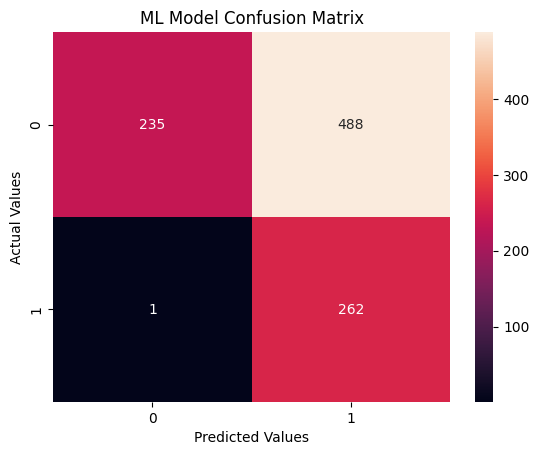

In [78]:
confusion_matrix(YTest,YPred)

sns.heatmap(confusion_matrix(YTest,YPred), annot = True, fmt='d')
plt.title('ML Model Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Vs the non-ML version:

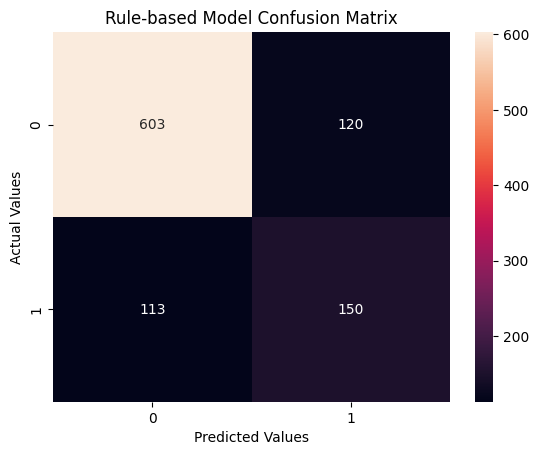

In [79]:
NonMLYPredTest = XTest.apply(NonML, axis = 1)
NonMLYPredTest = NonMLYPredTest.map({'Yes': 1, 'No': 0})
sns.heatmap(confusion_matrix(YTest, NonMLYPredTest), annot = True, fmt='d')
plt.title('Rule-based Model Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

The very high recall score of the ML model comes at the cost of a much lower precision score.

This might require that Telco subscribes to services such as email marketing software to send the retention campaigns to all of the customers the model deems at risk of churning.

As of 29 September 2024, a Mailchimp subscription allowing for 1500 contacts costs 45 USD/month. Additional costs may be included if more strategies are used, such as special new product discounts, referral programs or upselling campaigns (Source: https://www.lifesight.io/blog/customer-retention-campaigns-with-examples)

However, the churn that can be avoided by doing this will generate massive profit in the long term: if only half of the extra positives detected manage to be retained using the model and the retention strategies (i.e. 56 extra retained customers):

Mean of 'MonthlyCharges' * 56 = 64.883032 USD * 56 = 3633.449792 USD

3633.45 more USD will be generated per month, i.e. 64.88x ROI on the subscription plan.

# Summary

The model specifications are as follows:
- Transformer: OneHot on all categorical data except for 'churn', and RobustScaler for 'tenure' and 'MonthlyCharges'
- Resampler: RandomUnderSampler
- Feature selector: RFE(n_features_to_select = 1)
- model: XGBClassifier(min_child_weight = 1, gamma = 0, learning_rate = 0.01, max_depth = 6, n_estimators = 200, reg_alpha = 0, reg_lambda = 1)

This model can reach a recall score of 0.996, allowing for far more detections of customers at risk of churning and saving profits from being lost, at the light cost of a slightly more expensive email marketing suite from which to launch the retention campaign.

The limits of the model are the same as the limits of the original dataset.

For numerical data, that is:

| Feature | Range |
|---|---|
| Tenure | 0 - 72 months |
| MonthlyCharges | 18.8 - 118.65 |

For categorical data, that is:

| Feature | Range |
|---|---|
| Dependents | Y/N |
| OnlineSecurity | Y/N/No Internet Service |
| OnlineBackup | Y/N/No Internet Service |
| InternetService | DSL/Fiber Optic/No |
| DeviceProtection | Y/N/No Internet Service |
| TechSupport | Y/N/No Internet Service |
| Contract | Month-to-month/One year/Two years |
| PaperlessBilling | Y/N |
| Churn | Y/N |

# Recommendations to Model

- Text mining of comments on our product may be useful in finding out more about customer sentiment about it, hopefully making future models more precise.
- More numerical data in the dataset, such as actual time spent on our products or whether the user gave any reviews (by way of ratings) for each of our products, can give us a more complete idea of where the churn is coming from.
- Adding a Customer ID and date to the dataset can help us be more confident in whether we should remove duplicates or not, which could have had an effect with the recall score of the model.

# Recommendations to Business

Assuming that we're only taking into account data available in the dataset:

- When issuing two-year contracts, it must be paired with frequent and consistent collaboration and taking feedback with the customers so that our services will always be the best option for them.
- Due to the high false positives left by the ML model, it may be prudent to subscribe to an email marketing suite to easily spread retention campaigns to customers the model considers at risk. Even retaining a few extra customers (We can set getting 30% of these extra 'at risk' customers to cover both the subscription and cost of additional retention strategies) can cover the cost of one of these suites, as recently mentioned.
 - Use various customer retention strategies to retain as many of these 'at risk' customers as possible and test their effectiveness to retain as many of the extra positives (Churn = Yes) as possible, further increasing returns on the subscription cost of the email marketing suites.

# Packaging and Downloading Final Model

In [88]:
import pickle

with open('Capstone3Model.pkl', 'wb') as f:
  pickle.dump(FinalModel, f)

with open('Capstone3Model.pkl', 'rb') as f:
  LoadModel = pickle.load(f)

LoadModel.predict(X)

LoadYPred = LoadModel.predict(XTest)
recall_score(YTest, LoadYPred)

np.float64(0.9961977186311787)